In [1]:
# numpy to perform vector operations
# expit for sigmoid function
# pandas for reading data from csv
# matplotlib for showing output plots

import numpy as np
from scipy.special import expit
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# initializing parameters as arrays of zeroes

# layersNodes - number of layers in the model

def initParams(layersNodes):

    params = {}

    for l in range(1, len(layersNodes)):

        params["w"+str(l)] = np.random.randn(*(layersNodes[l], layersNodes[l-1])) * 0.01
        params["b"+str(l)] = np.zeros((layersNodes[l], 1), dtype=np.float32)

    return params

In [3]:
# making random minbatches from given data

# X - inputs
# Y - outputs
# miniBatchSize - size of the minibatches to be made

def randomMiniBatches(X, Y, miniBatchSize):
    
    examples = X.shape[1]
    perm = list(np.random.permutation(examples))
    X = X[:, perm]
    Y = Y[:, perm].reshape(1, examples)
    miniBatches = []

    for j in range(examples//miniBatchSize):

        miniBatchX = X[:, j*miniBatchSize:(j+1)*miniBatchSize]
        miniBatchY = Y[:, j*miniBatchSize:(j+1)*miniBatchSize]

        miniBatch = (miniBatchX, miniBatchY)
        miniBatches.append(miniBatch)

    if examples%miniBatchSize!=0:

        miniBatchX = X[:, -(examples%miniBatchSize):]
        miniBatchY = Y[:, -(examples%miniBatchSize):]

        miniBatch = (miniBatchX, miniBatchY)
        miniBatches.append(miniBatch)

    return miniBatches

In [4]:
# update paramters using the current values, gradients and the learning rate

# params - dictionary of paramaters
# grads - dictionary of gradients
# lr - learning rate

def updateParamsWithGD(params, grads, lr):

    for l in range(1, 1+len(params)//2):
        # print(params["w"+str(l)].shape, grads["dw"+str(l)].shape, params["b"+str(l)].shape, grads["db"+str(l)].shape)
        params["w"+str(l)] -= lr*grads["dw"+str(l)]
        params["b"+str(l)] -= lr*grads["db"+str(l)]

    return params

In [5]:
# initialize the velocity vectors to be 0, to be used for upgrading parametrs with momentum

# params - dictionary of parameters

def initVelocity(params):

    v = {}
    
    for l in range(1, 1+len(params)//2):

        v["dw"+str(l)] = np.zeros(params["w"+str(l)].shape, dtype=np.float32)
        v["db"+str(l)] = np.zeros(params["b"+str(l)].shape, dtype=np.float32)

    return v

# upgrading paramters with momentum

# params - dictionary of paramters
# grads - dictionatry of gradients
# v - dictionary of velocities, first moment
# beta - exponential decay rate for the first moment estimates
# lr - learning rate

def updateParamsWithMomentum(params, grads, v, beta, lr):

    for l in range(1, 1+len(params)//2):

        v["dw"+str(l)] = beta*v["dw"+str(l)] + (1-beta)*grads["dw"+str(l)]
        params["w"+str(l)] -= lr*v["dw"+str(l)]

        v["db"+str(l)] = beta*v["db"+str(l)] + (1-beta)*grads["db"+str(l)]
        params["b"+str(l)] -= lr*v["db"+str(l)]

    return params, v

In [6]:
# initializing the parameters to be 0, used for adam optimization algorithm

# params - dictionary of parameters

def initAdam(params):

    v = {}
    s = {}
    
    for l in range(1, 1+len(params)//2):

        v["dw"+str(l)] = np.zeros(params["w"+str(l)].shape, dtype=np.float32)
        v["db"+str(l)] = np.zeros(params["b"+str(l)].shape, dtype=np.float32)
        s["dw"+str(l)] = np.zeros(params["w"+str(l)].shape, dtype=np.float32)
        s["db"+str(l)] = np.zeros(params["b"+str(l)].shape, dtype=np.float32)

    return v, s

# upgrading paramters with adam optimization algorithm

# params - dictionary of paramters
# grads - dictionatry of gradients
# v - first moment estimates
# s - second moment estimates
# beta1 - exponential decay rate for the first moment estimates
# beta2 - exponential decay rate for the second moment estimates
# t - time step, or iteration number
# lr - learning rate
# epsilon - to avoid zero division error

def updateParamsWithAdam(params, 
                         grads, 
                         v, 
                         s, 
                         t, 
                         beta1 = 0.9, 
                         beta2 = 0.999, 
                         lr = 0.01, 
                         epsilon = 1e-8):

    v_corrected = {}
    s_corrected = {}

    for l in range(1, 1+len(params)//2):

        v["dw"+str(l)] = beta1*v["dw"+str(l)] + (1-beta1)*grads["dw"+str(l)]
        v_corrected["dw"+str(l)] = v["dw"+str(l)] / (1-beta1**t)

        s["dw"+str(l)] = beta2*s["dw"+str(l)] + (1-beta2)*np.square(grads["dw"+str(l)])
        s_corrected["dw"+str(l)] = s["dw"+str(l)] / (1-beta2**t)

        params["w"+str(l)] -= lr * v_corrected["dw"+str(l)] / np.sqrt(s_corrected["dw"+str(l)] + epsilon)
        
        v["db"+str(l)] = beta1*v["db"+str(l)] + (1-beta1)*grads["db"+str(l)]
        v_corrected["db"+str(l)] = v["db"+str(l)] / (1-beta1**t)

        s["db"+str(l)] = beta2*s["db"+str(l)] + (1-beta2)*np.square(grads["db"+str(l)])
        s_corrected["db"+str(l)] = s["db"+str(l)] / (1-beta2**t)

        params["b"+str(l)] -= lr * v_corrected["db"+str(l)] / np.sqrt(s_corrected["db"+str(l)] + epsilon)

    return params, v, s

In [7]:
# implementing forward propogation

# miniBatchX - mini batch of the inputs
# params - model parameters

def forwardProp(miniBatchX, params):

    caches = [{"w": [], "b": [], "z": None, "a": miniBatchX}]
    L = len(params)//2
    
    for l in range(1, L):

        cache = {}
        cache["w"] = params["w"+str(l)]
        cache["b"] = params["b"+str(l)]
        zl = np.dot(cache["w"], caches[-1]["a"]) + cache["b"]
        cache["z"] = zl
        al = zl * (zl > 0)
        cache["a"] = al
        caches.append(cache)
        
    cache = {}
    cache["w"] = params["w"+str(L)]
    cache["b"] = params["b"+str(L)]
    zl = np.dot(cache["w"], caches[-1]["a"]) + cache["b"]
    cache["z"] = zl
    al = expit(zl)
    cache["a"] = al
    caches.append(cache)

    return al, caches

In [8]:
# compute the loss function

# al - final output of the model
# miniBatchY - output for the mini batch
# epsilon - to avoid zero in logarithm

def computeCost(al, miniBatchY, epsilon):

    miniBatchSize = miniBatchY.shape[1]
    cost = -np.mean(miniBatchY*np.log(al+epsilon)+(1-miniBatchY)*np.log(1-al+epsilon))

    return cost

In [9]:
# implementing back propogation 

# miniBatchX - mini batch of the inputs
# miniBatchY - output for the mini batch
# caches - dictionary of gradients in the current iteration
# epsilon - to avoid zero division

def backwardProp(miniBatchX, miniBatchY, caches):

    miniBatchSize = miniBatchX.shape[1]
    dzl = caches[-1]["a"] - miniBatchY
    grads = {}

    for l in range(len(caches)-1, 0, -1):

        grads["dw"+str(l)] = (1/miniBatchSize) * np.dot(dzl, caches[l-1]["a"].T)
        grads["db"+str(l)] = (1/miniBatchSize) * np.squeeze(np.sum(dzl, axis=1, keepdims=True)).reshape(-1, 1)
       
        dal = np.dot(caches[l]["w"].T, dzl)
        dzl = dal * (caches[l-1]["z"] > 0) if l != 1 else None

    return grads

In [38]:
# final model

# X - inputs
# Y - outputs
# layersNodes - number of layers in the model
# optimizer - optimizer for updating the paramters, takes values "gd", "gd with momentum" and "adam"
# beta/beta1/beta2 - value of the decay rate
# epsilon - zero division/logarithm correction
# numEpochs - number of epochs to run the model for
# printCost - whether to print the cost after every epoch or not

def model(X, Y, layersNodes, optimizer="gd", miniBatchSize=64, lr=0.00001, beta=0.9, beta1=0.9, beta2=0.999, epsilon=1e-8, numEpochs=10000, printCost=True):

    numLayers = len(layersNodes)
    costs = []
    examples = X.shape[1]

    params = initParams(layersNodes)
    '''for param in params:
        print(param, params[param].shape)'''

    if optimizer=="gd":
        pass
    elif optimizer=="gd with momentum":
        v = initVelocity(params)
    elif optimizer=="adam":
        v, s = initAdam(params)
        t = 0

    for i in range(1, 1+numEpochs):

        epochCost = 0
        miniBatches = randomMiniBatches(X, Y, miniBatchSize)

        for miniBatch in miniBatches:

            miniBatchX, miniBatchY = miniBatch
            al, caches = forwardProp(miniBatchX, params)
            miniBatchCost = computeCost(al, miniBatchY, epsilon)
            epochCost += miniBatchCost
            grads = backwardProp(miniBatchX, miniBatchY, caches)
            '''for grad in grads:
                print(grad, grads[grad].shape)'''

            if optimizer == "gd":
                params = updateParamsWithGD(params, grads, lr)
            elif optimizer == "gd with momentum":
                params, v = updateParamsWithMomentum(params, grads, v, beta, lr)
            elif optimizer == "adam":
                t += 1
                params, v, s = updateParamsWithAdam(params, grads, v, s, t, lr, beta1, beta2, epsilon)

        if i%(numEpochs//100) == 0:
            epochCost /= examples
            costs.append(epochCost)
        
        if printCost and i%(numEpochs//10) == 0:
            print ("Cost after epoch %i: %f" % (i, epochCost))

    return params, costs

In [11]:
# making predictions using model parameters

# x - inputs
# y - outputs
# params - model parameters

def predict(x, y, params, epsilon=1e-8):
    
    predictions, _ = forwardProp(x, params)
    cost = computeCost(predictions, y, epsilon)
    
    return predictions, cost

In [12]:
df = pd.read_csv("heart.csv")
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,41,1,2,130,214,0,0,168,0,2.0,1,0,2,1
1,61,0,0,130,330,0,0,169,0,0.0,2,0,2,0
2,44,1,1,130,219,0,0,188,0,0.0,2,0,2,1
3,35,1,0,126,282,0,0,156,1,0.0,2,0,3,0
4,59,0,0,174,249,0,1,143,1,0.0,1,0,2,0


In [13]:
x, y = df[df.columns.difference(["target"])], df["target"]

x_train, x_test = x[:int(.8*x.shape[0])].values.T, x[int(.8*x.shape[0]):].values.T
y_train, y_test = y[:int(.8*y.shape[0])].values.reshape(1, -1), y[int(.8*y.shape[0]):].values.reshape(1, -1)

In [39]:
params, costs = {}, {}
for optimizer in ["gd", "gd with momentum", "adam"]:
    print("\nUsing optimizer", optimizer, "\n")
    params[optimizer], costs[optimizer] = model(X = x_train, 
                                                Y = y_train, 
                                                layersNodes = [x_train.shape[0], 10, 10, 1], 
                                                optimizer = optimizer,
                                                miniBatchSize = 64, 
                                                lr = 0.0001, 
                                                beta = 0.9, 
                                                beta1 = 0.9, 
                                                beta2 = 0.999, 
                                                epsilon = 1e-8, 
                                                numEpochs = 10000, 
                                                printCost = True)


Using optimizer gd 

Cost after epoch 1000: 0.011449
Cost after epoch 2000: 0.011442
Cost after epoch 3000: 0.011431
Cost after epoch 4000: 0.011438
Cost after epoch 5000: 0.011428
Cost after epoch 6000: 0.011421
Cost after epoch 7000: 0.011421
Cost after epoch 8000: 0.011416
Cost after epoch 9000: 0.011413
Cost after epoch 10000: 0.011420

Using optimizer gd with momentum 

Cost after epoch 1000: 0.011445
Cost after epoch 2000: 0.011438
Cost after epoch 3000: 0.011426
Cost after epoch 4000: 0.011431
Cost after epoch 5000: 0.011422
Cost after epoch 6000: 0.011411
Cost after epoch 7000: 0.011403
Cost after epoch 8000: 0.011401
Cost after epoch 9000: 0.011397
Cost after epoch 10000: 0.011368

Using optimizer adam 

Cost after epoch 1000: 0.012362
Cost after epoch 2000: 0.012277
Cost after epoch 3000: 0.012259
Cost after epoch 4000: 0.011558
Cost after epoch 5000: 0.011533
Cost after epoch 6000: 0.011946
Cost after epoch 7000: 0.012485
Cost after epoch 8000: 0.013223
Cost after epoch 900

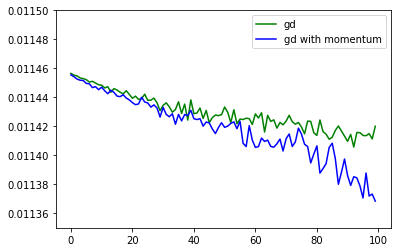

In [43]:
for optimizer, color in zip(["gd", "gd with momentum"], ["g", "b"]):
    
    plt.plot(costs[optimizer], color, label=optimizer)
    plt.ylim(0.01135, 0.0115)
    
plt.legend()
plt.show()

In [46]:
for optimizer in ["gd", "gd with momentum"]:
    
    print("Using", optimizer)
    prob_predictions, cost = predict(x_test, y_test, params[optimizer])
    print("Test cost =", round(cost / x_test.shape[1], 6))
    threshhold = 0.5
    predictions = [0 if x<threshhold else 1 for x in prob_predictions[0]]
    print("Test accuracy =", round(np.mean([0 if x != y else 1 for x, y in zip(predictions, y_test[0])]), 6))

Using gd
Test cost = 0.011263
Test accuracy = 0.57377
Using gd with momentum
Test cost = 0.011199
Test accuracy = 0.57377
